Install Packages

In [11]:
!pip install -q transformers accelerate einops



Load Qwen3-0.6B Model

In [12]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "Qwen/Qwen3-0.6B"

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,  # reduce memory
    device_map="auto",          # auto to GPU if available
    trust_remote_code=True
)

print("Number of transformer layers:", len(model.model.layers)) # print layer count


Number of transformer layers: 28


Testing Prompt

In [13]:
prompt = "Q: If you have 12 apples and eat 5, then buy 3 more, how many do you have?\nA: Let's think step by step."
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = model.generate(
    **inputs,
    max_new_tokens=100,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
)

decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Truncate at the next question (if any)
answer = decoded.split("\nQ:")[0].strip()

print(answer)


Q: If you have 12 apples and eat 5, then buy 3 more, how many do you have?
A: Let's think step by step. The first step is to subtract 5 from the total number of apples. So, we have 12 apples, and we eat 5, which leaves us with 12 - 5 = 7 apples. Next, we buy 3 more apples. Therefore, the total number of apples after these actions is 7 + 3 = 10. So, the answer should be 10.
The answer is 10.


# Linear Probe

Loading Dataset

In [14]:
from huggingface_hub import login
from google.colab import userdata

# Get your secret token from Colab Secrets
HF_TOKEN = userdata.get('HF_TOKEN')

# Pass the token directly
login(token=HF_TOKEN)


In [15]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
dataset = load_dataset("codelion/Qwen3-0.6B-pts", split="train")

# Print total number of samples
print(f"Total samples: {len(dataset)}")

# View the first example
print(dataset[0])

# Optionally: show the keys available
print(dataset[0].keys())

# View a few entries
for i in range(3):
    print(f"\nSample {i}:\n{dataset[i]}")


Total samples: 1376
{'model_id': 'Qwen/Qwen3-0.6B', 'query': 'Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?', 'pivot_context': 'Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn? \n\n', 'pivot_token': 'A', 'pivot_token_id': 32, 'prob_before': 0.68, 'prob_after': 0.0, 'prob_delta': -0.68, 'is_positive': False, 'task_type': 'generic', 'dataset_id': 'openai/gsm8k', 'dataset_item_id': '1', 'timestamp': datetime.datetime(2025, 5, 13, 14, 0, 26)}
dict_keys(['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp'])

Sample 0:
{'model_id': 'Qwen/Qwen3-0.6B', 'query': 'Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?', 'pivot_context': 'Weng earns $12 an hour for babysittin

Probing

In [16]:
import torch.nn as nn

activations = []

def get_hook(layer_idx):
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            activations[layer_idx] = output[0]
        else:
            activations[layer_idx] = output
    return hook_fn



layer_num = 12  # Example: 12th transformer block
model.model.layers[layer_num].register_forward_hook(get_hook(layer_num))



In [32]:
import random

X = []
y = []

layers_to_probe = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]  # Adjust depending on your model depth
hooks = []
activations = {}

# Register hooks BEFORE the dataset loop
def get_hook(layer_idx):
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            activations[layer_idx] = output[0]
        else:
            activations[layer_idx] = output
    return hook_fn

for layer_idx in layers_to_probe:
    block = model.model.layers[layer_idx]
    hooks.append(block.register_forward_hook(get_hook(layer_idx)))

# Go through the dataset
for sample in dataset:
    context = sample["pivot_context"]
    pivot_token = sample["pivot_token"]

    inputs = tokenizer(context, return_tensors="pt").to("cuda")
    token_ids = inputs["input_ids"][0].tolist()

    pivot_tok_id = tokenizer(pivot_token, add_special_tokens=False)["input_ids"][0]

    # Find the position of the pivot token (first occurrence)
    try:
        pivot_pos = token_ids.index(pivot_tok_id)
    except ValueError:
        continue  # pivot token not found in context

    # Choose a random negative token that is not the pivot
    neg_token_ids = [i for i, tid in enumerate(token_ids) if tid != pivot_tok_id]
    if not neg_token_ids:
        continue

    neg_pos = random.choice(neg_token_ids)

    activations.clear()
    with torch.no_grad():
        _ = model(**inputs)

    # Only once per sample
    X.append({layer_idx: activations[layer_idx][0, pivot_pos].cpu().numpy()
          for layer_idx in layers_to_probe})
    y.append(1)

    X.append({layer_idx: activations[layer_idx][0, neg_pos].cpu().numpy()
          for layer_idx in layers_to_probe})
    y.append(0)

for layer_idx in layers_to_probe:
    # Positive sample
    pos_rep = activations[layer_idx][0, pivot_pos]
    X.append(pos_rep.cpu().numpy())
    y.append(1)

    # Negative sample
    neg_rep = activations[layer_idx][0, neg_pos]
    X.append(neg_rep.cpu().numpy())
    y.append(0)


# Remove hooks
for hook in hooks:
    hook.remove()

In [18]:
import random

# After collecting X and y:
from collections import Counter
from sklearn.utils import resample

# Separate
X_pos = [x for x, label in zip(X, y) if label == 1]
X_neg = [x for x, label in zip(X, y) if label == 0]

# Downsample negatives to match positives
X_neg_downsampled = resample(X_neg, replace=False, n_samples=len(X_pos), random_state=42)

# Combine again
X_balanced = X_pos + X_neg_downsampled
y_balanced = [1]*len(X_pos) + [0]*len(X_neg_downsampled)


In [35]:
pip install matplotlib


Filtered dataset size: 1436

Checking layer 0
Layer 0: Accuracy = 0.743

Checking layer 3
Layer 3: Accuracy = 0.760

Checking layer 6
Layer 6: Accuracy = 0.785

Checking layer 9
Layer 9: Accuracy = 0.753

Checking layer 12
Layer 12: Accuracy = 0.767

Checking layer 15
Layer 15: Accuracy = 0.750

Checking layer 18
Layer 18: Accuracy = 0.792

Checking layer 21
Layer 21: Accuracy = 0.736

Checking layer 24
Layer 24: Accuracy = 0.743

Checking layer 27
Layer 27: Accuracy = 0.719


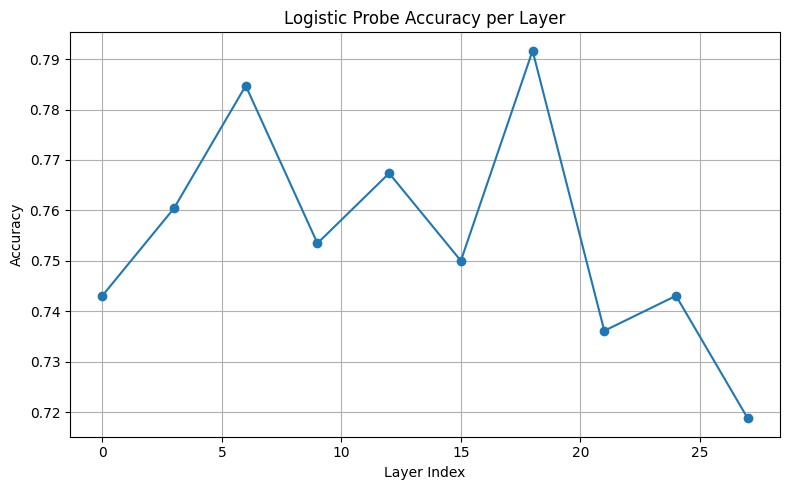

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

filtered_X = []
filtered_y = []

# Filter out malformed entries
for rep, label in zip(X, y):
    valid = True
    for layer_idx in layers_to_probe:
        if layer_idx not in rep or not isinstance(rep[layer_idx], np.ndarray) or rep[layer_idx].shape != (1024,):
            valid = False
            break
    if valid:
        filtered_X.append(rep)
        filtered_y.append(label)

print(f"Filtered dataset size: {len(filtered_X)}")

# Track accuracy for each layer
layer_accuracies = []

for layer_idx in layers_to_probe:
    print(f"\nChecking layer {layer_idx}")

    # Stack into matrix
    layer_X = np.stack([rep[layer_idx] for rep in filtered_X])
    X_train, X_test, y_train, y_test = train_test_split(layer_X, filtered_y, test_size=0.2, random_state=42)

    # Train probe
    clf = LogisticRegression(max_iter=5000)
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    layer_accuracies.append(acc)

    print(f"Layer {layer_idx}: Accuracy = {acc:.3f}")

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(layers_to_probe, layer_accuracies, marker='o')
plt.title("Logistic Probe Accuracy per Layer")
plt.xlabel("Layer Index")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()
